In [4]:
import pandas as pd
import geopandas as gpd
import shapely as sp

# Config

In [5]:
# true leading and trailing edge datasets
trail = pd.read_excel('true_lims/true_trailing_edge_data_for_christian.xlsx')
lead = pd.read_excel('true_lims/true_leading_edge_data_for_christian.xlsx')

trail['estimated_2019'] = trail.intercept + 2019 * trail.slope
lead['estimated_2019'] = lead.intercept + 2019 * lead.slope

trail = trail.loc[trail.end_year >= 2014].reset_index(drop = True)
lead = lead.loc[lead.end_year >= 2014].reset_index(drop = True)

# obtain all fish scientific names for species we have Aquamaps data for
fishnames = pd.read_csv('species_lists/fish_fullnames.csv')
missing = pd.read_csv('species_lists/missing_species.csv')

missing['sci_name'] = [f"{missing.genus[i]} {missing.species[i]}" for i in range(len(missing))]
fishnames['sci_name'] = [f"{fishnames.genus[i]} {fishnames.species[i]}" for i in range(len(fishnames))]
f = fishnames.loc[~fishnames.sci_name.isin(missing.sci_name)].reset_index(drop = True)

# restrict dataframes trail and head to only include fish listed in f
trail = trail.loc[trail.accepted_name.isin(f.sci_name)].reset_index(drop = True)
lead = lead.loc[lead.accepted_name.isin(f.sci_name)].reset_index(drop = True)

trail['most_recent'] = trail.intercept + trail.end_year * trail.slope
lead['most_recent'] = lead.intercept + lead.end_year * lead.slope

In [6]:
gdf = gpd.read_file('/Users/jameswagner/Dropbox/Mac/Desktop/Fish Ranges/MEOW/meow_ecos.shp')

In [7]:
gdf.columns

Index(['ECO_CODE', 'ECOREGION', 'PROV_CODE', 'PROVINCE', 'RLM_CODE', 'REALM',
       'ALT_CODE', 'ECO_CODE_X', 'Lat_Zone', 'geometry'],
      dtype='object')

In [8]:
gdf.ECOREGION.loc[gdf.ECO_CODE_X == 169]

46    Cocos Islands
Name: ECOREGION, dtype: object

In [9]:
# defining north-american ecoregion id's in an np array
atlantic_namer = [63, 42, 62, 38, 39, 40, 41, 42, 5, 6, 7]
# gulf of mexico: 69, 43, 70
# caribbearn: 67, 68, 65, 64

atlantic_euro = [27, 26, 25, 24, 21, 22, 23]
# iceland: 20, 2
# mediterranean: 30, 31, 32, 33, 34, 35, 36


pacific_namer = [170, 168, 167, 166, 164,
                60, 61, 59, 58, 57, 56, 55, 54]
# Clipperton: 165
# Cocos Islands: 169
# Aleutian Islands: 53
# bearing sea: 14

In [10]:
gdf.loc[gdf.ECO_CODE_X == 29]

,ECO_CODE,ECOREGION,PROV_CODE,PROVINCE,RLM_CODE,REALM,ALT_CODE,ECO_CODE_X,Lat_Zone,geometry
13,20029.0,Azores Canaries Madeira,3.0,Lusitanian,2.0,Temperate Northern Atlantic,36.0,29.0,Temperate,"MULTIPOLYGON (((-16.39408 26.37686, -19.20883 ..."


In [11]:
gdf.columns

Index(['ECO_CODE', 'ECOREGION', 'PROV_CODE', 'PROVINCE', 'RLM_CODE', 'REALM',
       'ALT_CODE', 'ECO_CODE_X', 'Lat_Zone', 'geometry'],
      dtype='object')

In [12]:
coast_labels = [None] * len(gdf)
ecoregions = ['atl_euro', 'atl_namer', 'pac_namer']
for i,code in enumerate(gdf.ECO_CODE_X):
    if code in atlantic_namer:
        coast_labels[i] = ecoregions[1]
    elif code in pacific_namer:
        coast_labels[i] = ecoregions[2]
    elif code in atlantic_euro:
        coast_labels[i] = ecoregions[0]

In [13]:
gdf['coast'] = coast_labels

In [14]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
coastal_gdf = gdf.groupby('coast')
coast_geoms = coastal_gdf['geometry'].apply(sp.unary_union)
coast_gdf = gpd.GeoDataFrame(geometry=coast_geoms, crs=gdf.crs)

In [16]:
coast_gdf.loc['atl_euro']

geometry    POLYGON ((-11.89763 35.42278, -11.95614 35.546...
Name: atl_euro, dtype: geometry

<Axes: >

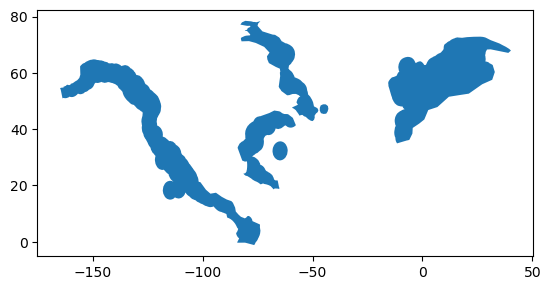

In [17]:
coast_gdf.plot()

# Prepare ECDF's for each coast in question

In [18]:
#Atlantic Europe, Atlantic North America, Pacific North America
ECDF = [{},{},{}]
HD_ECDF = [{},{},{}]

In [19]:
prob_cutoff = 0.80

In [20]:
ecoregions

['atl_euro', 'atl_namer', 'pac_namer']

In [21]:
# this is the same process followed in true_range_limits.ipynb, but subsetting for each coastline
for i in range(len(f)):
    g = f.genus.loc[i].lower()
    s = f.species.loc[i].lower()
    filepath = f'fish_data/{g}_{s}.csv'
    full_map = pd.read_csv(filepath)

    # subdivide into each of the three coastal regional maps
    points = [sp.Point(lat, lon) for lon,lat in zip(full_map['Center Lat'], full_map['Center Long'])]
    maps = []
    for ecoreg in ecoregions:
        maps.append(full_map.loc[coast_gdf.loc[ecoreg].geometry.contains(points)])
        # fills the maps in the following order: Atlantic Europe, Atlantic North America, Pacific North America

    # calculate north-south ecdfs for each map
    for j,map in enumerate(maps):
        net_density = map.groupby('Center Lat')['Overall Probability'].sum().reset_index().sort_values(by = 'Center Lat')
        net_density['PMF'] = net_density['Overall Probability'] / net_density['Overall Probability'].sum()
        net_density['ECDF'] = net_density['PMF'].cumsum()

        ECDF[j][f.sci_name.loc[i]] = net_density[['Center Lat', 'ECDF']]
        ECDF[j][f.sci_name.loc[i]].columns = ['latitude', 'ecdf']


    
    # repeat for only cells with probability higher than the specified prob_cutoff
    hd_maps = []
    for map in maps:
        hd_maps.append(map.loc[map['Overall Probability'] >= prob_cutoff].reset_index(drop=True))

    # calculate north-south ecdfs for each map
    for j,map in enumerate(hd_maps):
        net_density = map.groupby('Center Lat')['Overall Probability'].sum().reset_index().sort_values(by = 'Center Lat')
        net_density['PMF'] = net_density['Overall Probability'] / net_density['Overall Probability'].sum()
        net_density['ECDF'] = net_density['PMF'].cumsum()

        HD_ECDF[j][f.sci_name.loc[i]] = net_density[['Center Lat', 'ECDF']]
        HD_ECDF[j][f.sci_name.loc[i]].columns = ['latitude', 'ecdf']

# Find coast-specific percentiles

In [22]:
ocean_continents = {'Atlantic Ocean-North America': 1, 'Atlantic Ocean-Europe': 0, 'Pacific Ocean-North America': 2}

In [23]:
def find_percentiles(lat, species_name, coast):
    # lat is in degrees north
    # species name is capital Genus lowercase species
    # coast is an integer 0-2
    raw_density = ECDF[coast][species_name]
    HD_density = HD_ECDF[coast][species_name]
    
    # first get the raw percentiles
    max_lat = raw_density.latitude.loc[raw_density.latitude <= lat].max()
    raw_percentile = raw_density.ecdf.loc[raw_density.latitude == max_lat].max()

    # now get the high density (prob >= 80%) percentiles
    hd_max_lat = HD_density.latitude.loc[HD_density.latitude <= lat].max()
    hd_percentile = HD_density.ecdf.loc[HD_density.latitude == hd_max_lat].max()

    return raw_percentile, hd_percentile

In [24]:
def percentile_of_calculated_edge(edge_col, name_col, region_col, edge_df):
    # edge_col is the string form of the column label which contains a float latitude in degrees north
    # name_col is the string form of the column label which contains the string species name
    # region_col is the string column label which contains the continent region
    # edge_df is a dataframe of calculated range edges
    raws = []
    hds = []

    for name,edge,coast in zip(edge_df[name_col], edge_df[edge_col], edge_df[region_col]):
        coastal_region = ocean_continents[coast]
        r,h = find_percentiles(edge, name, coastal_region)
        raws.append(r)
        hds.append(h)

    return [raws, hds]

In [25]:
trail_percentiles = percentile_of_calculated_edge('estimated_2019', 'accepted_name', 'ocean_continent', trail)
lead_percentiles = percentile_of_calculated_edge('estimated_2019', 'accepted_name', 'ocean_continent', lead)

In [26]:
trail['raw_percentile'] = trail_percentiles[0]
trail['hd_percentile'] = trail_percentiles[1]

In [27]:
lead['raw_percentile'] = lead_percentiles[0]
lead['hd_percentile'] = lead_percentiles[1]

# Verification

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

(array([ 15.,  14.,  21.,  29.,  36.,  51.,  63.,  53.,  77., 207.]),
 array([0.02357934, 0.12122141, 0.21886348, 0.31650554, 0.41414761,
        0.51178967, 0.60943174, 0.7070738 , 0.80471587, 0.90235793,
        1.        ]),
 <BarContainer object of 10 artists>)

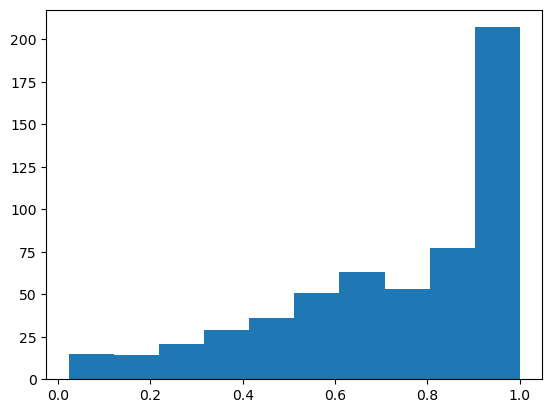

In [29]:
plt.hist(lead.hd_percentile)

(array([136., 104.,  85.,  50.,  34.,  25.,  16.,  17.,   9.,   4.]),
 array([0.00219557, 0.10197601, 0.20175645, 0.3015369 , 0.40131734,
        0.50109778, 0.60087823, 0.70065867, 0.80043911, 0.90021956,
        1.        ]),
 <BarContainer object of 10 artists>)

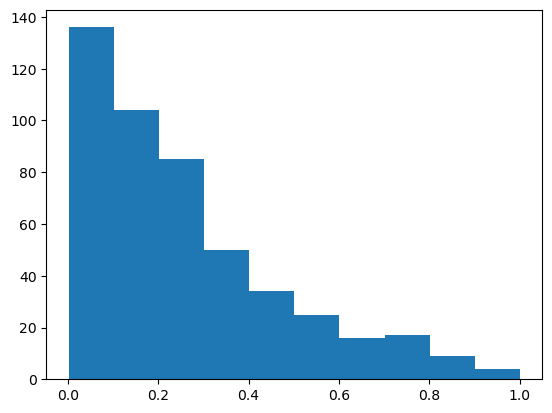

In [30]:
plt.hist(trail.hd_percentile)

In [31]:
import arviz as az
import numpy as np

In [32]:
az.hdi(np.array(lead.raw_percentile.dropna()), 0.60).round(2), az.hdi(np.array(trail.raw_percentile.dropna()), 0.60).round(2)

(array([0.68, 1.  ]), array([0.  , 0.32]))

In [33]:
az.hdi(np.array(lead.hd_percentile.dropna()), 0.60).round(2), az.hdi(np.array(trail.hd_percentile.dropna()), 0.60).round(2)

(array([0.7, 1. ]), array([0.  , 0.25]))